In [2]:
import pandas as pd
import numpy as np
from textblob import TextBlob
import re 
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [3]:
data = pd.read_csv('train.csv')
data=data[['text']]
data.tail()

,text
16431,thinks lamb chops would be really nice right a...
16432,FC is back dear.
16433,ONE OF THE WORST DAYS OF MY LIFE.
16434,sunburnt again
16435,Spending a weekend doing nothing but being do...


In [ ]:
data = data.dropna()
data = data.reset_index()
data['text'].astype(str)

In [5]:
def decontracted(phrase):
  # specific
  phrase = phrase.lower()
  phrase = re.sub(r"won't", "will not", phrase)
  phrase = re.sub(r"can\'t", "can not", phrase)
  # general
  phrase = re.sub(r"n\'t", " not", phrase)
  phrase = re.sub(r"\'re", " are", phrase)
  phrase = re.sub(r"\'s", " is", phrase)
  phrase = re.sub(r"\'d", " would", phrase)
  phrase = re.sub(r"\'ll", " will", phrase)
  phrase = re.sub(r"\'t", " not", phrase)
  phrase = re.sub(r"\'ve", " have", phrase)
  phrase = re.sub(r"\'m", " am", phrase)
  phrase = re.sub('[^A-Za-z0-9]+', ' ', phrase)
  phrase = re.sub('https?://\S+|www\.\S+', '', phrase)
  phrase = phrase.replace('\\r', ' ')
  phrase = phrase.replace('\\"', ' ')
  phrase = phrase.replace('\\n', ' ')

  return phrase

In [6]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren','won']

In [8]:
from tqdm import tqdm
cleaned_text = []
# tqdm is for printing the status bar
for sentance in tqdm(data['text'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    cleaned_text.append(sent.lower().strip())

100%|██████████| 16435/16435 [00:00<00:00, 23955.86it/s]


In [9]:
data['cleaned_text']=cleaned_text

In [12]:
data.head(2)

,index,text,cleaned_text
0,0,"I`d have responded, if I were going",responded going
1,1,Sooo SAD I will miss you here in San Diego!!!,sooo sad miss san diego


In [13]:
X=data['cleaned_text'].values
print(X.shape)

(16435,)


In [14]:
split=int(len(X)*0.8)
print(split)
X_train, X_test =X[:split], X[split:]

13148


In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
print("="*70)
print("Before vectorizations:")
print("-"*70)
print("shape of X_train=", X_train.shape)
print("shape of X_train=", X_test.shape)
print("="*70)
vectorizer = TfidfVectorizer(min_df=10,ngram_range=(1, 2))

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


print("After vectorizations:")
print("-"*70)
print("shape of X_train_tfidf=", X_train_tfidf.shape)
print("shape of X_test_tfidf=", X_test_tfidf.shape)
print("="*70)


Before vectorizations:
----------------------------------------------------------------------
shape of X_train= (13148,)
shape of X_train= (3287,)
After vectorizations:
----------------------------------------------------------------------
shape of X_train_tfidf= (13148, 1596)
shape of X_test_tfidf= (3287, 1596)


In [90]:
#https://blog.cambridgespark.com/how-to-determine-the-optimal-number-of-clustrs-for-k-means-clustering-14f27070048f
from sklearn.cluster import KMeans

sum_of_squared_distances = []
K_hyperparameter= range(1,15)
for i in tqdm(K_hyperparameter):
  km = KMeans(n_clusters=i,n_jobs=-1)
  km = km.fit(X_train_tfidf )
  sum_of_squared_distances.append(km.inertia_)



100%|██████████| 14/14 [03:28<00:00, 14.88s/it]


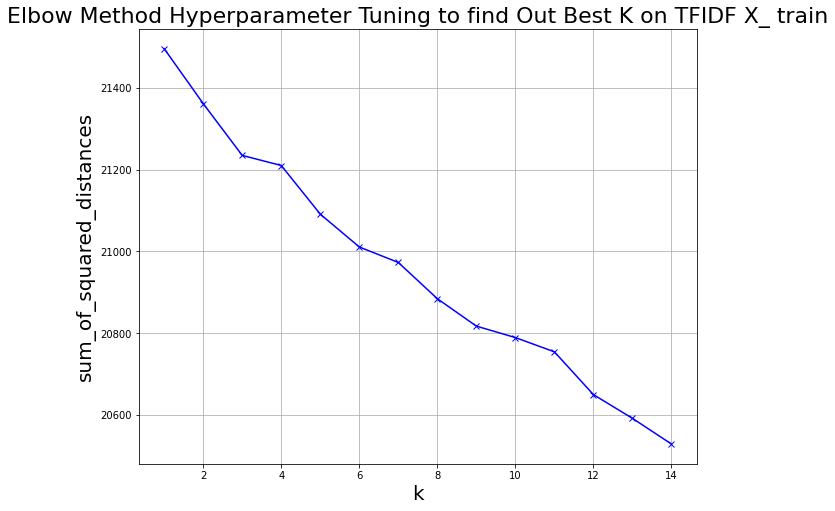

In [15]:
plt.figure(figsize=(10,8))
plt.grid()
plt.plot(K_hyperparameter,
         sum_of_squared_distances, 'bx-')
plt.xlabel('k',fontsize=20)
plt.ylabel('sum_of_squared_distances',
           fontsize=20)
plt.title('Elbow Method Hyperparameter Tuning to find Out Best K on TFIDF X_ train',
          fontsize=22)
plt.show()

In [72]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2)
kmeans=kmeans.fit(X_train_tfidf )
y_means= kmeans.predict(X_train_tfidf )
cluster_centers_ = kmeans.cluster_centers_
y_labels=kmeans.labels_


In [77]:
#refrences::#https://github.com/dileepteja3/Clustering-on-Donors-choose/blob/master/dileep.teja3%40gmail.com_10.ipynb

text = X_train
words_text_datapoints=[]
cluster1_words = ' '
cluster2_words = ' '

for i in range(kmeans.labels_.shape[0]):
  if kmeans.labels_[i] == 0:
    words_text_datapoints.append(1)
    cluster1_words+=text[i]

  else:
    kmeans.labels_[i] == 1
    words_text_datapoints.append(1)
    cluster2_words+=text[i]

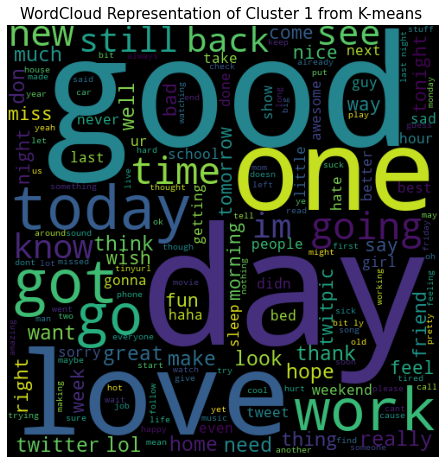

In [80]:
from wordcloud import WordCloud
wordcloud = WordCloud(width = 500, height = 500,
                      background_color ='black',
                      min_font_size = 10).generate(cluster1_words)
# plot the WordCloud image
plt.figure(figsize = (6, 6))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title('WordCloud Representation of Cluster 1 from K-means ',fontsize=15)
plt.show()


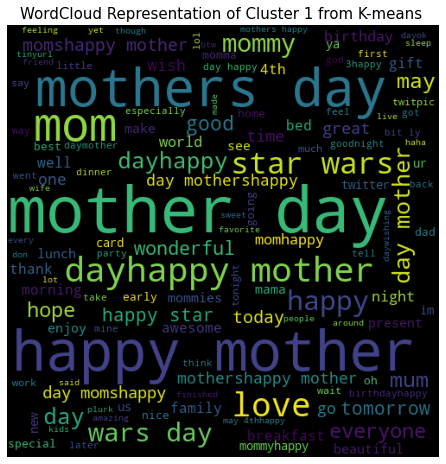

In [79]:
from wordcloud import WordCloud
wordcloud = WordCloud(width = 500, height = 500,
                      background_color ='black',
                      min_font_size = 10).generate(cluster2_words)
# plot the WordCloud image
plt.figure(figsize = (6, 6))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title('WordCloud Representation of Cluster 2 from K-means ',fontsize=15)
plt.show()


In [17]:
data.head(2)

,index,text,cleaned_text
0,0,"I`d have responded, if I were going",responded going
1,1,Sooo SAD I will miss you here in San Diego!!!,sooo sad miss san diego


In [18]:
data['label'] = ''
for i in range(data.shape[0]):
  label = TextBlob(data['text'].iloc[i])
  data['label'][i] = label.sentiment.polarity
  #print("Index: ", i ,  "label" , label.sentiment.polarity)

In [19]:
data['label_on_cleaned_text'] = ''
for i in range(data.shape[0]):
  label = TextBlob(data['cleaned_text'].iloc[i])
  data['label_on_cleaned_text'][i] = label.sentiment.polarity
  #print("Index: ", i ,  "label" , label.sentiment.polarity)

In [20]:
data.head(3)

,index,text,cleaned_text,label,label_on_cleaned_text
0,0,"I`d have responded, if I were going",responded going,0,0
1,1,Sooo SAD I will miss you here in San Diego!!!,sooo sad miss san diego,-0.976562,-0.5
2,2,my boss is bullying me...,boss bullying,0,0


In [21]:
data[['label','label_on_cleaned_text']].head(5)

,label,label_on_cleaned_text
0,0,0
1,-0.976562,-0.5
2,0,0
3,0,0
4,0,0


In [22]:
data = data.reset_index()
data['label_on_cleaned_text'].replace('', np.nan, inplace=True)
data['label_on_cleaned_text'].dropna()

0        0.000000
1       -0.500000
2        0.000000
3        0.000000
4        0.000000
           ...   
16430    0.378571
16431    0.000000
16432   -1.000000
16433    0.000000
16434    0.000000
Name: label_on_cleaned_text, Length: 16435, dtype: float64

In [23]:
type(data.label[500])

float

In [181]:
#data.shape

In [24]:
def polarity_to_label(x):
    if(x >= 0.01 ):
      return 1
    else:
      return 0

In [207]:
#polarity_to_label(0.20005)

1

In [208]:
#data.columns

Index(['text', 'label'], dtype='object')

In [210]:
#type(data.label[0])

In [209]:
#data.label = data.label.astype(float)

In [212]:
#polarity_to_label(data.label[500])

1

In [15]:
#print(count)

In [25]:
data["binary_label"] = data['label'].apply(polarity_to_label)

In [26]:
data.head(1)

,level_0,index,text,cleaned_text,label,label_on_cleaned_text,binary_label
0,0,0,"I`d have responded, if I were going",responded going,0,0.0,0


In [27]:
data["binary_label_cleaned_text"] = data['label_on_cleaned_text'].apply(polarity_to_label)

In [28]:
data.head(1)

,level_0,index,text,cleaned_text,label,label_on_cleaned_text,binary_label,binary_label_cleaned_text
0,0,0,"I`d have responded, if I were going",responded going,0,0.0,0,0


In [29]:
data=data[['text',
            'cleaned_text', 
            'label','label_on_cleaned_text', 
            'binary_label',
            'binary_label_cleaned_text']]

In [30]:
data.columns

Index(['text', 'cleaned_text', 'label', 'label_on_cleaned_text',
       'binary_label', 'binary_label_cleaned_text'],
      dtype='object')

In [31]:
data.binary_label_cleaned_text.value_counts(normalize=True)

0    0.552905
1    0.447095
Name: binary_label_cleaned_text, dtype: float64

In [32]:
data.binary_label.value_counts(normalize=True)

0    0.538789
1    0.461211
Name: binary_label, dtype: float64

Text(0.5, 1.0, 'Binary_label_distibution')

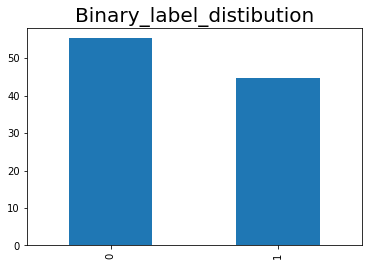

In [33]:
((data.binary_label_cleaned_text.value_counts()/len(data))*100).plot(kind='bar')
plt.title("Binary_label_distibution",fontsize=20)

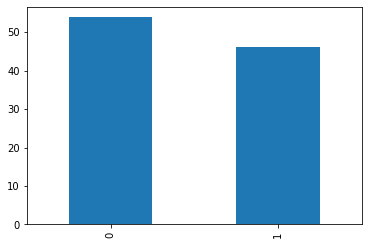

In [34]:
((data.binary_label.value_counts()/len(data))*100).plot(kind='bar')

27480

In [35]:
data.columns

Index(['text', 'cleaned_text', 'label', 'label_on_cleaned_text',
       'binary_label', 'binary_label_cleaned_text'],
      dtype='object')

In [36]:
X_for_NB=data['cleaned_text']
y_for_NB=data['binary_label_cleaned_text']

In [37]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_for_NB,
                                                    y_for_NB,
                                                    test_size=0.2, 
                                                    stratify=y_for_NB)

In [38]:
type(X_train)

pandas.core.series.Series

In [39]:
print("="*70)
print("Before vectorizations")
print("-"*70)
print("shape of X_train:", X_train.shape, ", shape of y_train :", y_train.shape)
print("shape of X_test:", X_test.shape,", shape of y_test:", y_test.shape)
print("="*70)

vectorizer = TfidfVectorizer(min_df=10)
X_train_tfidf_NB=vectorizer.fit_transform(X_train.values)

X_test_tfidf_NB=vectorizer.transform(X_test.values)


print("After vectorizations")
print("-"*70)
print("shape of X_train_tfidf_NB:",X_train_tfidf_NB.shape,
      ", shape of y_train: ",y_train.shape)
print("shape of X_test_tfidf_NB:", X_test_tfidf_NB.shape,
      ", shape of y_test:", y_test.shape)
print("="*70)

Before vectorizations
----------------------------------------------------------------------
shape of X_train: (13148,) , shape of y_train : (13148,)
shape of X_test: (3287,) , shape of y_test: (3287,)
After vectorizations
----------------------------------------------------------------------
shape of X_train_tfidf_NB: (13148, 1360) , shape of y_train:  (13148,)
shape of X_test_tfidf_NB: (3287, 1360) , shape of y_test: (3287,)


In [40]:
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV
import math
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

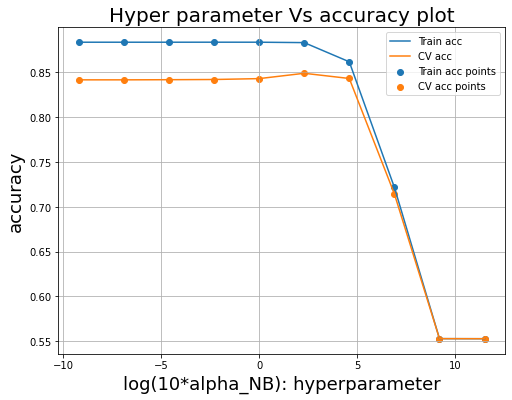

Best_hyperparameter_NB_tfidf: {'alpha': 1}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
9,0.003121,0.000078,0.000445,0.000035,1e-05,{'alpha': 1e-05},0.853992,0.838023,0.839544,0.83346,0.840304,0.856274,0.847909,0.851711,0.821157,0.831811,0.841418,0.010532,6,0.880757,0.883462,0.883969,0.883715,0.884222,0.883631,0.8838,0.879828,0.885499,0.884654,0.883354,0.001644


In [41]:
###https://stackoverflow.com/questions/57136676/sklearn-model-selection-gridsearchcv-is-throwing-keyerror-mean-train-score

NB = MultinomialNB(alpha=i)
parameters = {'alpha':[0.00001,0.0001, 
                       0.001, 0.01,
                       0.1, 1,10, 100, 
                       1000, 10000,100000]}
clf = RandomizedSearchCV(NB,
                         parameters, 
                         cv=10, 
                         scoring='accuracy',
                         return_train_score=True)
clf.fit(X_train_tfidf_NB, y_train) 

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_alpha'])

train_acc= results['mean_train_score']
train_acc_std= results['std_train_score']
cv_acc = results['mean_test_score'] 
cv_acc_std=results['std_test_score']
alpha_NB = results['param_alpha']

log_alpha_NB=[]
for i in alpha_NB:
    x=math.log(10*i)
    log_alpha_NB.append(x)

plt.figure(figsize=(8,6))
plt.plot(log_alpha_NB, train_acc, label='Train acc')
plt.plot(log_alpha_NB, cv_acc, label='CV acc')

plt.scatter(log_alpha_NB, train_acc, label='Train acc points')
plt.scatter(log_alpha_NB, cv_acc, label='CV acc points')

plt.legend()
plt.xlabel("log(10*alpha_NB): hyperparameter",fontsize=18)
plt.ylabel("accuracy",fontsize=18)
plt.title("Hyper parameter Vs accuracy plot",fontsize=20)
plt.grid()
plt.show()


best_alpha=clf.best_params_
print("="*100)
print("Best_hyperparameter_NB_tfidf:",best_alpha)
Best_hyperparameter_NB_tfidf=best_alpha.get("alpha")
print("="*100)
results.head(1)

1

In [42]:
NB = MultinomialNB(alpha=best_alpha['alpha'])
NB.fit(X_train_tfidf_NB, y_train)

y_train_pred = NB.predict(X_train_tfidf_NB)
y_test_pred = NB.predict(X_test_tfidf_NB)

print("="*80)
print("Train Accuracy using Naive Bayes Classifier:",
      accuracy_score(y_train,y_train_pred))
print("-"*80)
print("Test Accuracy using Naive Bayes Classifier:",
      accuracy_score(y_test,y_test_pred))
print("="*80)

Train Accuracy using Naive Bayes Classifier: 0.8821113477334956
--------------------------------------------------------------------------------
Test Accuracy using Naive Bayes Classifier: 0.8548828719196836


In [43]:
data.head(5)

,text,cleaned_text,label,label_on_cleaned_text,binary_label,binary_label_cleaned_text
0,"I`d have responded, if I were going",responded going,0,0.0,0,0
1,Sooo SAD I will miss you here in San Diego!!!,sooo sad miss san diego,-0.976562,-0.5,0,0
2,my boss is bullying me...,boss bullying,0,0.0,0,0
3,what interview! leave me alone,interview leave alone,0,0.0,0,0
4,"Sons of ****, why couldn`t they put them on t...",sons couldn put releases already bought,0,0.0,0,0


In [126]:
#

In [44]:
df=data[['cleaned_text', 'binary_label_cleaned_text']].sample(4000)
df.head()

,cleaned_text,binary_label_cleaned_text
13335,everyone left gone bed,0
4570,bbcrew dude im sleepy went bed soon got home w...,0
16389,oh thank thank hoping video online,0
5889,haha hi mum wow yes modern need get facebook a...,1
5868,need men give input fill u time soon,0


In [45]:
df.binary_label_cleaned_text.value_counts()/len(df)

0    0.55575
1    0.44425
Name: binary_label_cleaned_text, dtype: float64

In [46]:
print(df.shape)

(4000, 2)


In [47]:
seq_length=df['cleaned_text'].apply(lambda x:len(x.split()))

<Figure size 576x576 with 0 Axes>

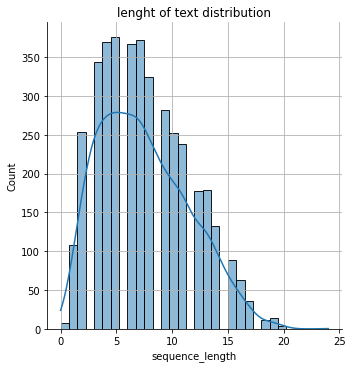

In [48]:
plt.figure(figsize=(8,8))
sns.displot(seq_length,kde='True')
plt.title("lenght of text distribution")
plt.xlabel("sequence_length")
plt.grid()
plt.show()

In [49]:
SEQ_LEN=32

In [52]:
#!pip install transformers

In [53]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [54]:
def tokenize(sentence):
    tokens = tokenizer.encode_plus(sentence, max_length=32,
                                   truncation=True, padding='max_length',
                                   add_special_tokens=True, return_token_type_ids=False,
                                   return_tensors='tf')
    return tokens['input_ids'], tokens['attention_mask']

In [55]:
Xids = np.zeros((len(df), 32))
Xmask = np.zeros((len(df), 32))

In [56]:
print("="*50)
print("shape of X_ids:",Xids.shape)
print("-"*50)
print("shape of X_mask:",Xids.shape)
print("="*50)

shape of X_ids: (4000, 32)
--------------------------------------------------
shape of X_mask: (4000, 32)


In [57]:
for i, sequence in enumerate(df['cleaned_text']):
    tokens = tokenize(sequence)
    Xids[i, :], Xmask[i, :] = tokens[0], tokens[1]

In [212]:
#Xmask

In [58]:
arr = df['binary_label_cleaned_text'].values
labels = np.zeros((arr.size, arr.max()+1))
print(arr.size)

4000


2000

In [59]:
labels[np.arange(arr.size), arr] = 1
labels

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [1., 0.],
       [1., 0.]])

In [146]:
#for i in range(len(labels)):
  #print(labels[i])

In [60]:
with open('tweet_xids.npy', 'wb') as f:
    np.save(f, Xids)
with open('tweet_xmask.npy', 'wb') as f:
    np.save(f, Xmask)
with open('tweet_labels.npy', 'wb') as f:
    np.save(f, labels)

In [61]:
del df, Xids, Xmask, labels

In [62]:
with open('tweet_xids.npy', 'rb') as f:
    Xids = np.load(f, allow_pickle=True)
with open('tweet_xmask.npy', 'rb') as f:
    Xmask = np.load(f, allow_pickle=True)
with open('tweet_labels.npy', 'rb') as f:
    labels = np.load(f, allow_pickle=True)

In [63]:
import tensorflow as tf

data = tf.data.Dataset.from_tensor_slices((Xids, Xmask, labels))

In [64]:
SHUFFLE = 100000
BATCH_SIZE = 16

In [65]:
def map_func(input_ids, masks, labels):
    return {'input_ids': input_ids, 'attention_mask': masks}, labels

In [66]:
data = data.map(map_func)

In [67]:

data = data.shuffle(SHUFFLE).batch(BATCH_SIZE)

In [68]:
SIZE = Xids.shape[0]/BATCH_SIZE
SIZE

250.0

In [69]:
SPLIT = 0.9

train = data.take(int(SIZE*SPLIT))
val = data.skip(int(SIZE*SPLIT))

del data

In [70]:
from transformers import TFAutoModel

In [71]:
bert = TFAutoModel.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [73]:
bert.summary()

Model: "tf_bert_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109482240 
Total params: 109,482,240
Trainable params: 109,482,240
Non-trainable params: 0
_________________________________________________________________


In [76]:
#https://github.com/jamescalam/transformers/blob/main/course/project_build_tf_sentiment_model/sentiment.ipynb
###https://djajafer.medium.com/multi-class-text-classification-with-keras-and-lstm-4c5525bef592

input_ids = tf.keras.layers.Input(shape=(32,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(32,), name='attention_mask', dtype='int32')

embeddings = bert.bert(input_ids, attention_mask=mask)[0]  # we access the transformer model within our bert object using the bert attribute (eg bert.bert instead of bert)

x = tf.keras.layers.Dropout(0.4)(embeddings)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(768))(x)
y = tf.keras.layers.Dense(2, activation='sigmoid', name='outputs')(x)

model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

model.layers[2].trainable = False

In [75]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 32)]         0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 32)]         0                                            
__________________________________________________________________________________________________
bert (TFBertMainLayer)          TFBaseModelOutputWit 109482240   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
dropout_37 (Dropout)            (None, 32, 768)      0           bert[0][0]                   

In [77]:
optimizer = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

In [78]:
history = model.fit(
    train,
    validation_data=val,
    epochs=10)

Epoch 1/10
225/225 [==============================] - 35s 85ms/step - loss: 0.6034 - accuracy: 0.6939 - val_loss: 0.5075 - val_accuracy: 0.7275
Epoch 2/10
225/225 [==============================] - 16s 73ms/step - loss: 0.5055 - accuracy: 0.7519 - val_loss: 0.3893 - val_accuracy: 0.8275
Epoch 3/10
225/225 [==============================] - 17s 73ms/step - loss: 0.4575 - accuracy: 0.7825 - val_loss: 0.3968 - val_accuracy: 0.8250
Epoch 4/10
225/225 [==============================] - 17s 74ms/step - loss: 0.4238 - accuracy: 0.8044 - val_loss: 0.3115 - val_accuracy: 0.8525
Epoch 5/10
225/225 [==============================] - 17s 74ms/step - loss: 0.4074 - accuracy: 0.8211 - val_loss: 0.3522 - val_accuracy: 0.8575
Epoch 6/10
225/225 [==============================] - 17s 75ms/step - loss: 0.3802 - accuracy: 0.8278 - val_loss: 0.2763 - val_accuracy: 0.8800
Epoch 7/10
225/225 [==============================] - 17s 74ms/step - loss: 0.3402 - accuracy: 0.8506 - val_loss: 0.2583 - val_accuracy:

In [115]:
#model.get_config()

In [79]:
model.save('sentiment_model')

INFO:tensorflow:Assets written to: sentiment_model/assets


INFO:tensorflow:Assets written to: sentiment_model/assets


In [80]:
bert_history=pd.DataFrame(history.history)

In [81]:
bert_history

,loss,accuracy,val_loss,val_accuracy
0,0.603385,0.693889,0.507507,0.7275
1,0.505473,0.751944,0.389264,0.8275
2,0.457467,0.782500,0.396833,0.8250
3,0.423770,0.804444,0.311460,0.8525
4,0.407440,0.821111,0.352169,0.8575
5,0.380186,0.827778,0.276313,0.8800
6,0.340154,0.850556,0.258340,0.8875
7,0.321867,0.858056,0.176185,0.9375
8,0.299644,0.872778,0.168115,0.9275
9,0.280973,0.876111,0.143452,0.9575


In [82]:
bert_history.columns

Index(['loss', 'accuracy', 'val_loss', 'val_accuracy'], dtype='object')

In [83]:
bert_history=bert_history[['accuracy', 'val_accuracy']]

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns

<Figure size 432x288 with 0 Axes>

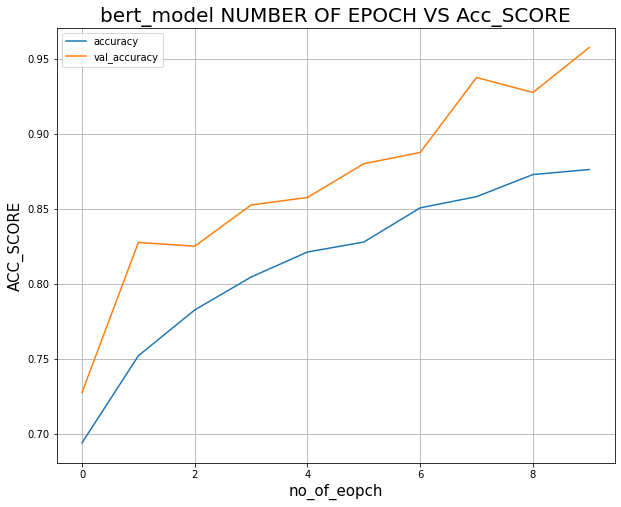

In [85]:
plt.figure()
ax=bert_history.plot(figsize=(10, 8))
ax.set_ylabel('ACC_SCORE',fontsize=15)
ax.set_xlabel('no_of_eopch',fontsize=15)
ax.set_title('bert_model NUMBER OF EPOCH VS Acc_SCORE',fontsize=20)
plt.grid()

In [86]:
loss, acc = model.evaluate(val)


25/25 [==============================] - 2s 59ms/step - loss: 0.1513 - accuracy: 0.9550


In [87]:
print("="*80)
print("Loss for bert with custom layer on validation dataset: ",loss)
print("-"*80)
print("Accuracy for bert with custom layer on validation dataset: ",acc)
print("="*80)

Loss for bert with custom layer on validation dataset:  0.15132656693458557
--------------------------------------------------------------------------------
Accuracy for bert with custom layer on validation dataset:  0.9549999833106995


In [88]:
y_pred_bert=model.predict(val)

In [89]:
y_pred_bert

array([[0.7650407 , 0.24623893],
       [0.92432916, 0.06431764],
       [0.51262194, 0.49369907],
       [0.98492277, 0.0140958 ],
       [0.8146161 , 0.18357316],
       [0.83063865, 0.1764851 ],
       [0.8400093 , 0.13721034],
       [0.9135893 , 0.08965964],
       [0.23216814, 0.8013962 ],
       [0.11939523, 0.8850974 ],
       [0.05482151, 0.9524249 ],
       [0.99528617, 0.00400707],
       [0.15560135, 0.8590332 ],
       [0.7778054 , 0.24882995],
       [0.13309562, 0.8493951 ],
       [0.91736704, 0.06588376],
       [0.38887608, 0.6436251 ],
       [0.5154037 , 0.5014468 ],
       [0.8485856 , 0.13838121],
       [0.05371962, 0.95102096],
       [0.39281127, 0.60989565],
       [0.02700846, 0.97631925],
       [0.79318327, 0.21861748],
       [0.401588  , 0.6081605 ],
       [0.21381162, 0.85125005],
       [0.8047562 , 0.18984742],
       [0.7088698 , 0.296566  ],
       [0.6736391 , 0.3414824 ],
       [0.1462759 , 0.8602969 ],
       [0.01797369, 0.9842402 ],
       [0.

In [18]:
from prettytable import PrettyTable
    
x = PrettyTable()
x.field_names = ["Sr No" ,"Problem type ", "Model", "Test Accuracy"]
x.add_row(["1","Unsupervised /Clustering ", "KMeans", '---'])
x.add_row(["2", "Converted into Binary classification\n using TextBlob ", 
           "Naive Bayes", '0.8548'])
x.add_row(["3", "Converted into Binary classification\n using TextBlob ", 
           "Bert(pretrained hugging face)\n With Custom layers 4000 Datapoints ", 
           '0.9549'])

print(x)

+-------+--------------------------------------+--------------------------------------+---------------+
| Sr No |            Problem type              |                Model                 | Test Accuracy |
+-------+--------------------------------------+--------------------------------------+---------------+
|   1   |      Unsupervised /Clustering        |                KMeans                |      ---      |
|   2   | Converted into Binary classification |             Naive Bayes              |     0.8548    |
|       |            using TextBlob            |                                      |               |
|   3   | Converted into Binary classification |    Bert(pretrained hugging face)     |     0.9549    |
|       |            using TextBlob            |  With Custom layers 4000 Datapoints  |               |
+-------+--------------------------------------+--------------------------------------+---------------+
